## Step 0: Setup



In [2]:
!pip install xgboost
!pip install matplotlib seaborn scikit-learn
!pip install kaggle


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aslanahmedov/walmart-sales-forecast")

print("Path to dataset files:", path)

100%|██████████| 3.36M/3.36M [00:00<00:00, 140MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/aslanahmedov/walmart-sales-forecast/versions/1


## Step 1: Import Libraries & Load Data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
train = pd.read_csv(path + '/train.csv')
features = pd.read_csv(path + '/features.csv')
stores = pd.read_csv(path + '/stores.csv')

print("Train shape:", train.shape)
train.head()

print("Features shape:", features.shape)
features.head()

print("Stores shape:", stores.shape)
stores.head()

Train shape: (421570, 5)
Features shape: (8190, 12)
Stores shape: (45, 3)


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


## Step 2: Merge Datasets & Basic Cleaning

In [6]:
# Merge all data into one dataframe
data = train.merge(features, on=['Store', 'Date'], how='left')
data = data.merge(stores, on='Store', how='left')

# Convert date to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Sort
data = data.sort_values(['Store', 'Dept', 'Date'])

# Check missing values
data.isnull().sum()

,0
Store,0
Dept,0
Date,0
Weekly_Sales,0
IsHoliday_x,0
Temperature,0
Fuel_Price,0
MarkDown1,270889
MarkDown2,310322
MarkDown3,284479


In [7]:
data = data.fillna(method='ffill')

/tmp/ipython-input-917065080.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


## Step 3: Exploratory Data Analysis (EDA)

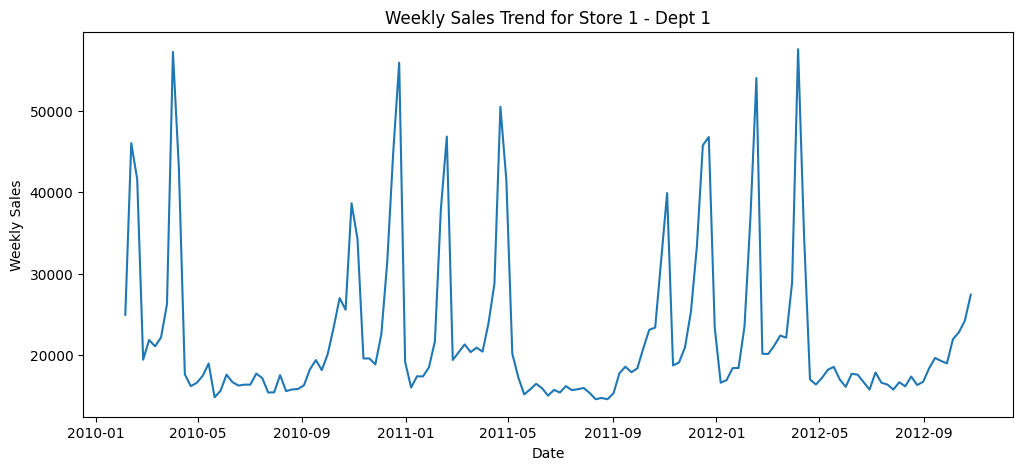

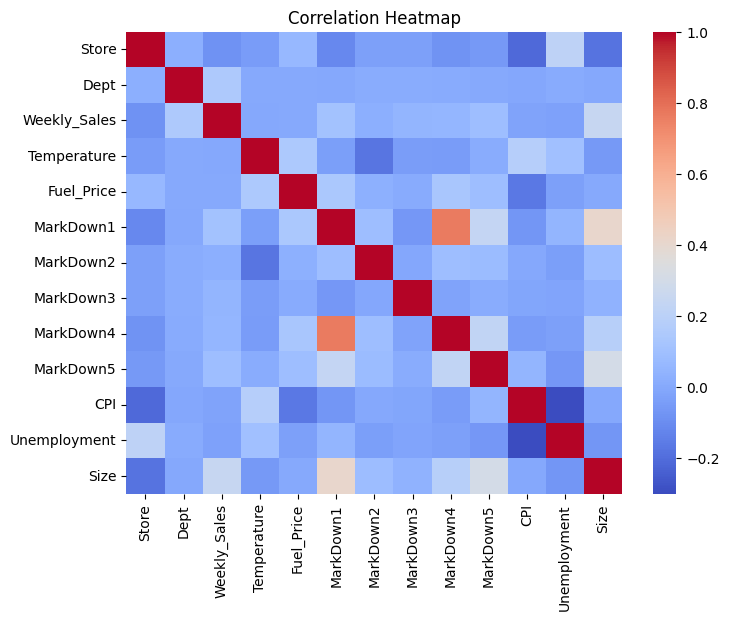

In [8]:
# Step 3: EDA

# Sample store & department
sample = data[(data['Store']==1) & (data['Dept']==1)]

plt.figure(figsize=(12,5))
plt.plot(sample['Date'], sample['Weekly_Sales'])
plt.title('Weekly Sales Trend for Store 1 - Dept 1')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

# Check correlation between numeric columns
plt.figure(figsize=(8,6))
sns.heatmap(data.select_dtypes(include=np.number).corr(), cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Step 4: Feature Engineering

In [9]:
# Step 4: Feature Engineering

data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Week'] = data['Date'].dt.isocalendar().week.astype(int)

# Lag features
data['Prev_Week_Sales'] = data.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
data['Prev_Year_Sales'] = data.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(52)

# Drop NaN rows caused by shift
data = data.dropna()

# Final feature set
feature_cols = [
    'Store', 'Dept', 'IsHoliday_x', 'Temperature', 'Fuel_Price',
    'CPI', 'Unemployment', 'Year', 'Month', 'Week',
    'Prev_Week_Sales', 'Prev_Year_Sales'
]

X = data[feature_cols]
y = data['Weekly_Sales']

## Step 5: Split Data & Train Model (XGBoost)

In [21]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Split Data and validate data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    L1_regularization=0.1,
    L2_regularization=0.1,
    eval_metric='rmse'
)
model.fit(X_train, y_train)
# Predict
y_pred = model.predict(X_val)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE: {rmse:.2f}")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:28:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "L1_regularization", "L2_regularization" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RMSE: 3412.47


In [22]:
average_weekly_sales = data['Weekly_Sales'].mean()
print(f"Average Weekly Sales: {average_weekly_sales:.2f}")

Average Weekly Sales: 16394.77


In [23]:
# Predict on training data
y_train_pred = model.predict(X_train)

# Evaluate training RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"Training RMSE: {rmse_train:.2f}")
print(f"Validation RMSE: {rmse:.2f}")

Training RMSE: 2282.97
Validation RMSE: 3412.47


## Step 6: Visualize Predictions

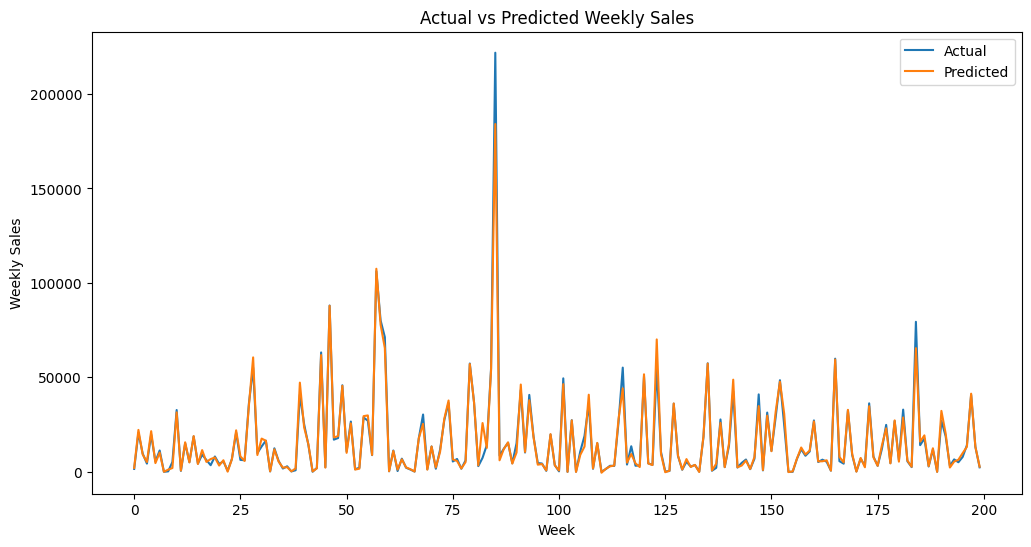

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(range(200), y_val.values[:200], label='Actual')
plt.plot(range(200), y_pred[:200], label='Predicted')
plt.title('Actual vs Predicted Weekly Sales')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()